In [6]:
from os import listdir
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import keras.layers as L
from keras.models import Model
from skimage.transform import resize
from keras.callbacks import ModelCheckpoint
from keras import optimizers

import keras, keras.layers as L
import keras.applications as zoo

from sklearn.model_selection import train_test_split

%matplotlib inline

In [7]:
names = sorted(listdir('public_data/00_input/train/images/'))

In [8]:
images = []
for name in names:
    images.append(imread('public_data/00_input/train/images/' + name))

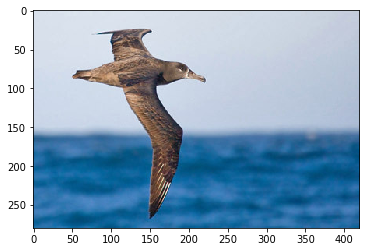

In [9]:
plt.imshow(images[4])

In [51]:
targets = pd.read_csv('public_data/00_gt/gt.csv')
pure_targets = np.array(targets.class_id)
targets.head()

,filename,class_id
0,0000.jpg,0
1,0001.jpg,0
2,0002.jpg,0
3,0003.jpg,0
4,0004.jpg,0


In [11]:
def show_image(image, target):
    plt.imshow(image)
    plt.title(target)
    plt.show()

In [28]:
small_images = []
input_shape = (224, 224, 3)
for image in images:
    small_images.append(resize(image, output_shape=input_shape))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [51]:
X_train, X_test, y_train, y_test = train_test_split(np.array(small_images), pure_targets, test_size=0.1)

In [3]:
model = zoo.ResNet50(include_top=True, weights='imagenet')
model.summary()

In [1]:
from keras.models import load_model
model = load_model('birds_model_best1.hdf5')

Using TensorFlow backend.


In [2]:
model.save('birds_model_best1_without.hdf5', include_optimizer=False)

In [53]:
count_classes = len(targets.class_id.unique())

resnet_layer = model.layers[-2].output
dropout = L.Dropout(0.25)(resnet_layer)
new_output = L.Dense(count_classes, activation='softmax')(dropout)

new_model = Model(inputs=[model.layers[0].input], output=[new_output])

for l in new_model.layers[:-50]:
    l.trainable = False
    
momentum = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

checkpoint = ModelCheckpoint('birds_model.hdf5', save_best_only=True)

new_model.compile(optimizer=momentum, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

new_model.fit(X_train, y_train, batch_size=20, epochs=7, callbacks=[checkpoint], validation_data=(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`
  import sys


Train on 2250 samples, validate on 250 samples
Epoch 1/7
1780/2250 [======================>.......] - ETA: 9:27 - loss: 3.3301 - acc: 0.1770

KeyboardInterrupt: 

In [35]:
from keras import backend as K
from keras.models import load_model
from os import environ
from os.path import abspath, dirname, join

from os import environ
from os.path import join
from sys import argv

def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            filename, class_id = line.rstrip('\n').split(',')
            res[filename] = int(class_id)
    return res

In [37]:
data_dir = 'public_data/00_input'


train_dir = join(data_dir, 'train')
test_dir = join(data_dir, 'test')

train_gt = read_csv(join(train_dir, 'gt.csv'))
train_img_dir = join(train_dir, 'images')

# train_classifier(train_gt, train_img_dir, fast_train=True)

# code_dir = dirname(abspath(__file__))
# model = load_model(join(code_dir, 'birds_model.hdf5'))
test_img_dir = join(test_dir, 'images')

In [39]:
directory = test_img_dir

In [55]:
def classify(model, directory):
    names = np.array(sorted(listdir(directory)))

    size = (100, 100, 3)
    test_images = []
    test_flipped_images = []

    batch_size = 500
    batch_count = (len(names) + batch_size - 1) // batch_size

    all_prediction = []
    input_shape = (299, 299, 3)

    for i in range(batch_count):
        test_images = []
        end = min(len(names), (i + 1) * batch_size)
        for name in names[i * batch_size: end]:
            image = imread(join(directory, name))
            image = zoo.inception_v3.preprocess_input(resize(image, output_shape=input_shape, mode='reflect')[None] * 255).reshape(299, 299, 3)
            test_images.append(image)

        test_images = np.array(test_images)
        test_flipped_images = test_images[:, :,::-1]

        prediction = model.predict(test_images)
        prediction_flipped = model.predict(test_flipped_images)

        prediction = (prediction + prediction_flipped) / 2
        prediction = np.argmax(prediction, axis=-1)

        if i == 0:
            all_prediction = prediction
        else:
            all_prediction = np.hstack((all_prediction, prediction))


    return dict(zip(names, all_prediction))

In [56]:
len(ans)

2500

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


def train_classifier(train_gt, train_img_dir, fast_train=True):
       if fast_train:
        epochs = 1
    else:
        epochs = 40
        
    size = (100, 100, 3)
    
    names = sorted(listdir(train_img_dir))
    names=names[:200]
    input_shape = (299, 299, 3)
    images = []
    y = []
    for i, name in enumerate(names):
        image = imread(join(train_img_dir, name))
        y.append(train_gt[name])
        image = zoo.inception_v3.preprocess_input(resize(image, output_shape=input_shape, mode='reflect')[None] * 255).reshape(299, 299, 3)
        images.append(image)
        
    train_datagen = ImageDataGenerator(
            rotation_range=30,
            zoom_range=0.2,
            horizontal_flip=True)

    train_datagen.fit(np.array(images), augment=True)
    X_aug = train_datagen.flow(np.array(images), y, batch_size=16)
    model = zoo.InceptionV3(include_top=True, weights='imagenet')

    count_classes = len(targets.class_id.unique())

    resnet_layer = model.layers[-2].output
    dropout = L.Dropout(0.1)(resnet_layer)
    new_output = L.Dense(count_classes, activation='softmax')(dropout)

    new_model = Model(inputs=[model.layers[0].input], output=[new_output])

    for l in new_model.layers[:-200]:
        l.trainable = False

    opt = optimizers.Adam(lr=0.0001)
    new_model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    new_model.fit_generator(X_aug, epochs=1, steps_per_epoch=len(X_train) // 16,
                  validation_steps=16, validation_data=(X_test, y_test))
    
    return new_model